# Explore Sound Visualization of Low Amplitude Ranges
##  Using "seven" utterances

Earl F Glynn

2017-12-10

# Purpose

Explore 

 * What is "silence"?  
  
 * How do spectrograms change when the amplitude range changes?
 
 * Is there an amplitude range below which wav files can be deemed to be "silence."

Based on [Sound-Visualization notebook](https://github.com/EarlGlynn/kaggle-speech-recognition/tree/master/Jupyter/01-Sound-WAV-visualization), which was adapted from Kaggle [Data visualization and investigation](https://www.kaggle.com/davids1992/data-visualization-and-investigation) by *DavisS*.

Find files of given amplitude min, max, range in the train/test WAV-File-Inventory files from [this Kaggle discussion thread](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/discussion/44687).

# Conclusions

* An amplitude range cutoff of perhaps 500 or less could be used to label a wav file as "silence."  This needs additional validation.

* Some noise filtering may be necessary.

* Time alignment at the beginning of an utternace seems necessary.

# Setup

In [1]:
import pandas as pd

Math

In [2]:
import librosa
import numpy    as np

from scipy.fftpack         import fft
from scipy                 import signal
from scipy.io              import wavfile

Visualization

In [3]:
import matplotlib.pyplot as plt
import pandas            as pd

import IPython.display   as ipd
import librosa.display

import plotly.offline    as py

py.init_notebook_mode(connected=True)

%matplotlib inline

Location of train audio files

In [4]:
trainAudioPath = '../../input/train/audio/'

## Helper Functions

[Format output of code cell with Markdown](https://stackoverflow.com/questions/32026727/format-output-of-code-cell-with-markdown)

In [5]:
from IPython.display import Markdown, display
def printMarkdown(string):
    display(Markdown(string))

Raw Wave File

In [6]:
def plotRawWave(plotTitle, sampleRate, samples, figWidth=14, figHeight=4):
    plt.figure(figsize=(figWidth, figHeight))
    plt.plot(np.linspace(0, sampleRate/len(samples), sampleRate), samples)
    plt.title("Raw sound wave of " + plotTitle)
    plt.ylabel("Amplitude")
    plt.xlabel("Time [sec]")
    plt.show()  # force display while in for loop
    return None

Spectrogram

In [7]:
def computeLogSpectrogram(audio, sampleRate, windowSize=20, stepSize=10, epsilon=1e-10):
    nperseg  = int(round(windowSize * sampleRate / 1000))
    noverlap = int(round(stepSize   * sampleRate / 1000))
    freqs, times, spec = signal.spectrogram(audio,
                                            fs=sampleRate,
                                            window='hann',
                                            nperseg=nperseg,
                                            noverlap=noverlap,
                                            detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + epsilon)

In [8]:
def plotLogSpectrogram(plotTitle, freqs, times, spectrogram, figWidth=14, figHeight=4):
    fig = plt.figure(figsize=(figWidth, figHeight))
    plt.imshow(spectrogram.T, aspect='auto', origin='lower', 
               cmap="inferno",   #  default was "viridis"  (perceptually uniform)
               extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    plt.colorbar(pad=0.01)
    plt.title('Spectrogram of ' + plotTitle)
    plt.ylabel("Frequency [Hz]")
    plt.xlabel("Time [sec]")
    fig.tight_layout()
    plt.show()  # force display while in for loop
    return None

Mel Spectrogram

In [9]:
def computeLogMelSpectrogram(samples, sampleRate, nMels=128):
    melSpectrum = librosa.feature.melspectrogram(samples, sr=sampleRate, n_mels=nMels)
    
    # Convert to dB, which is a log scale.  Use peak power as reference.
    logMelSpectrogram = librosa.power_to_db(melSpectrum, ref=np.max)
    
    return logMelSpectrogram

In [10]:
def plotLogMelSpectrogram(plotTitle, sampleRate, logMelSpectrum, figWidth=14, figHeight=4):
    fig = plt.figure(figsize=(figWidth, figHeight))
    librosa.display.specshow(logMelSpectrum, sr=sampleRate, x_axis='time', y_axis='mel')
    plt.title('Mel log-frequency power spectrogram: ' + plotTitle)
    plt.colorbar(pad=0.01, format='%+02.0f dB')
    plt.tight_layout()  
    plt.show()  # force display while in for loop
    return None

Compute and plot MFCC

In [11]:
def computeMFCC(samples, sampleRate, nFFT=512, hopLength=256, nMFCC=40):
    mfcc = librosa.feature.mfcc(y=samples, sr=sampleRate, 
                                n_fft=nFFT, hop_length=hopLength, n_mfcc=nMFCC)
    
    # Let's add on the first and second deltas  (what is this really doing?)
    #mfcc = librosa.feature.delta(mfcc, order=2)
    return mfcc

In [12]:
def plotMFCC(plotTitle, sampleRate, mfcc, figWidth=14, figHeight=4):
    fig = plt.figure(figsize=(figWidth, figHeight))
    librosa.display.specshow(mfcc, sr=sampleRate, x_axis='time', y_axis='mel')
    plt.colorbar(pad=0.01)
    plt.title("Mel-frequency cepstral coefficients (MFCC): " + plotTitle)
    plt.tight_layout()
    plt.show()  # force display while in for loop
    return None

Plot waveform along with the above three spectrum alternatives

In [13]:
def showWavefile(filename):
    sampleRate, samples = wavfile.read(filename)  
    plotRawWave(filename, sampleRate, samples)
    
    freqs, times, logSpectrogram = computeLogSpectrogram(samples, sampleRate)
    plotLogSpectrogram(filename, freqs, times, logSpectrogram)
    
    logMelSpectrogram = computeLogMelSpectrogram(samples, sampleRate)
    plotLogMelSpectrogram(filename, sampleRate, logMelSpectrogram)
    
    mfcc = computeMFCC(samples, sampleRate)
    print(mfcc.shape)
    plotMFCC(filename, sampleRate, mfcc)
    
    return sampleRate, samples, logSpectrogram, logMelSpectrogram, mfcc

# Low Amplitude Waveforms

... and a some high amplitude waveforms for comparison.

List files to explore in data structure .

Here, we look for amplitude ranges near powers of 2.

For now, only works with files with exactly 16000 samples.

In [14]:
labels = ['filename', 'comments']
waves  = [
          ('seven/712e4d58_nohash_2.wav',  # 10
           'Noise.'),
    
          ('seven/099d52ad_nohash_4.wav',  # 29
           'Noise.'),

          ('seven/ced835d3_nohash_3.wav',  # 132
           'Unintelligible, noise.'),

          ('seven/7846fd85_nohash_0.wav',  # 265
           'Unintelligible, noise.'),

          ('seven/aff582a1_nohash_0.wav',  # 591
           'clicks with noise.' ),
 
          ('seven/3c165869_nohash_0.wav',  # 1049
           '"seven"'),  
    
          ('seven/e82914c0_nohash_0.wav',  # 2084
           '"seven"'),

          ('seven/fb7cfe0e_nohash_0.wav',  # 4114
           '"seven"'),
                                                                                                    
          ('seven/9ff1b8b6_nohash_1.wav',  # 8193
           'Muffled "seven"'),
    
          ('seven/28ed6bc9_nohash_4.wav',  # 16440
           '"seven"'),

           ('seven/471a0925_nohash_3.wav',  # 32800
           'noisy "seven"'),
                                                                                  
          ('seven/facd97c0_nohash_0.wav',  # 65535
           'LOUD "seven"')
         ]                  

wavedf = pd.DataFrame.from_records(waves, columns=labels)
wavedf

,filename,comments
0,seven/712e4d58_nohash_2.wav,Noise.
1,seven/099d52ad_nohash_4.wav,Noise.
2,seven/ced835d3_nohash_3.wav,"Unintelligible, noise."
3,seven/7846fd85_nohash_0.wav,"Unintelligible, noise."
4,seven/aff582a1_nohash_0.wav,clicks with noise.
5,seven/3c165869_nohash_0.wav,"""seven"""
6,seven/e82914c0_nohash_0.wav,"""seven"""
7,seven/fb7cfe0e_nohash_0.wav,"""seven"""
8,seven/9ff1b8b6_nohash_1.wav,"Muffled ""seven"""
9,seven/28ed6bc9_nohash_4.wav,"""seven"""


# Display waveforms and related spectrograms

Need this trick below:  [More than one Audio object in a Jupyter Notebook cell](https://stackoverflow.com/questions/33048353/more-than-one-audio-object-in-a-jupyter-ipython-notebook-cell).

# "seven" [amplitude from -6 to 4, range = 10]

Noise.


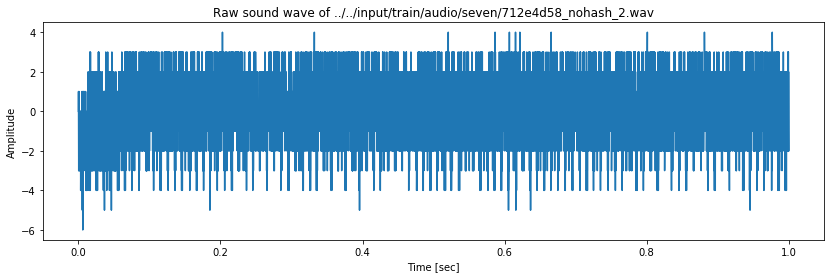

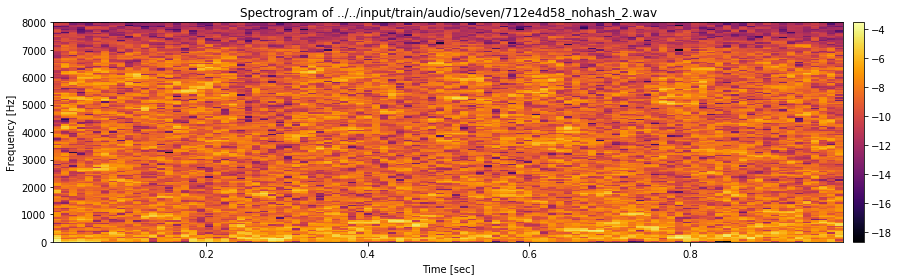

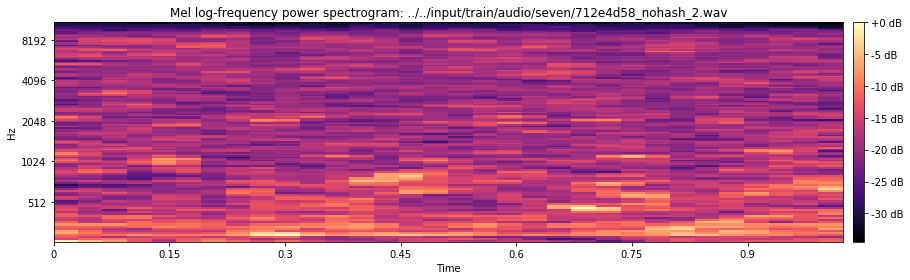

(40, 63)


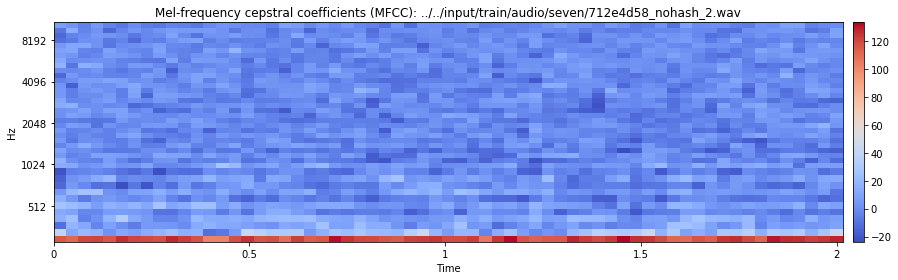

# "seven" [amplitude from -14 to 15, range = 29]

Noise.


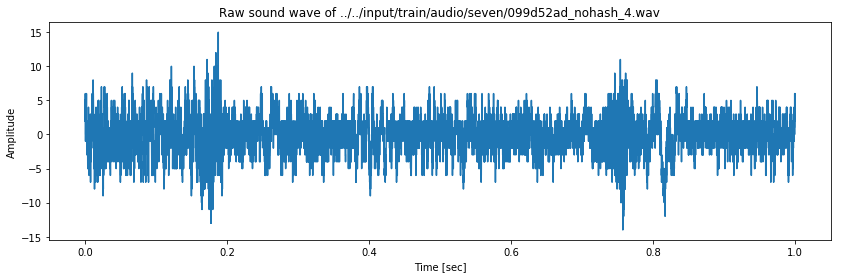

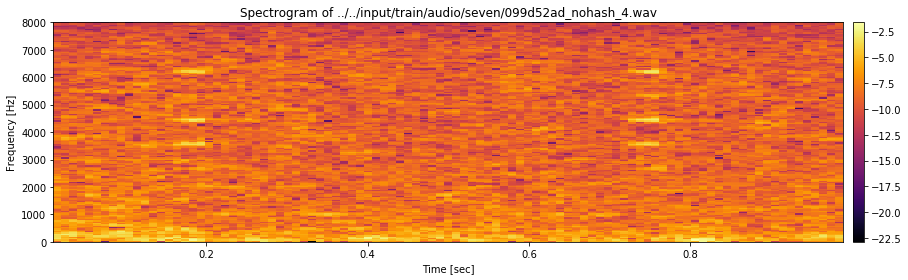

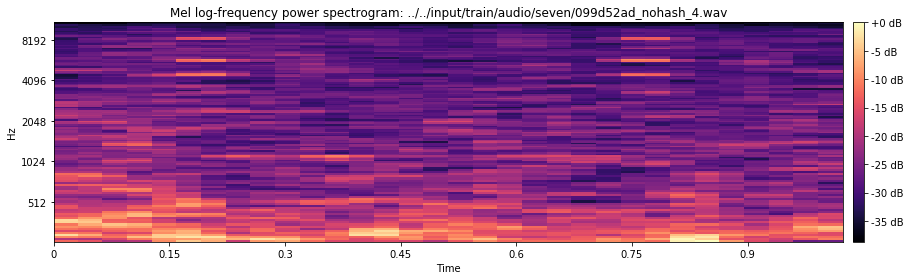

(40, 63)


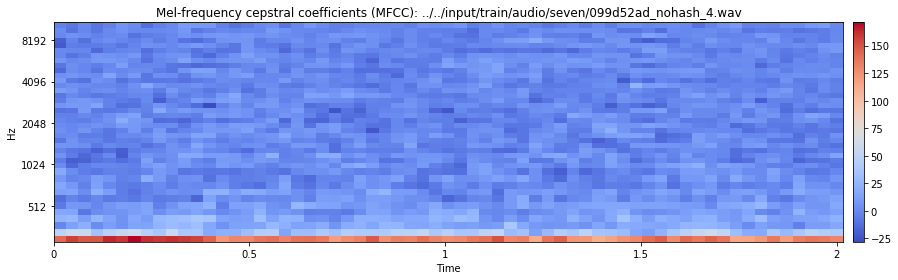

# "seven" [amplitude from -59 to 73, range = 132]

Unintelligible, noise.


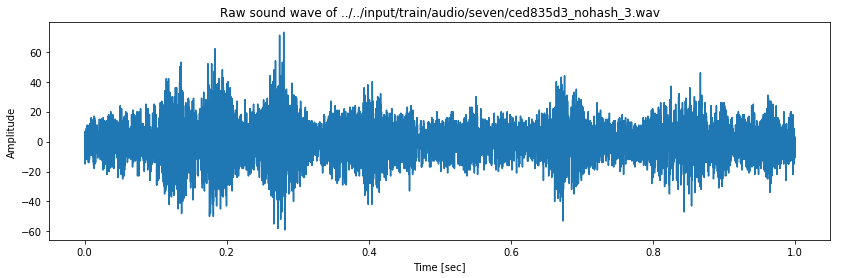

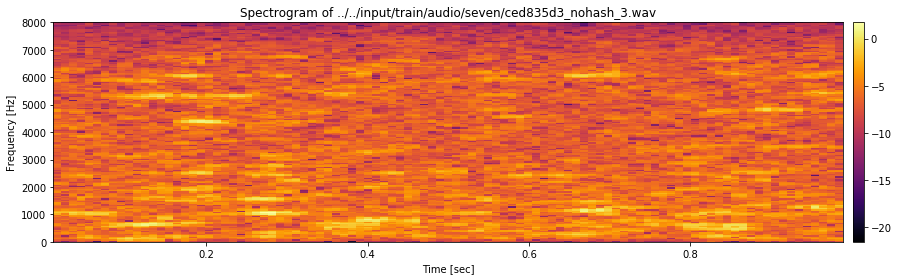

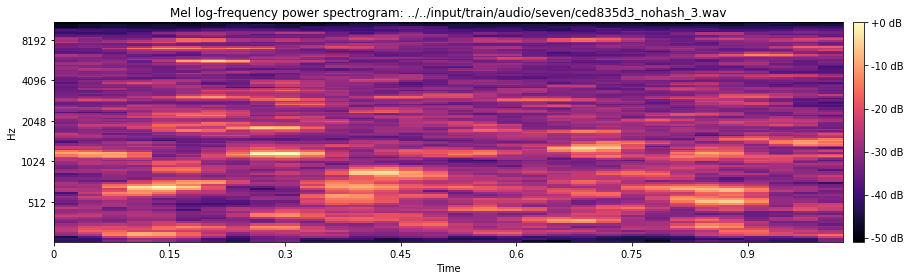

(40, 63)


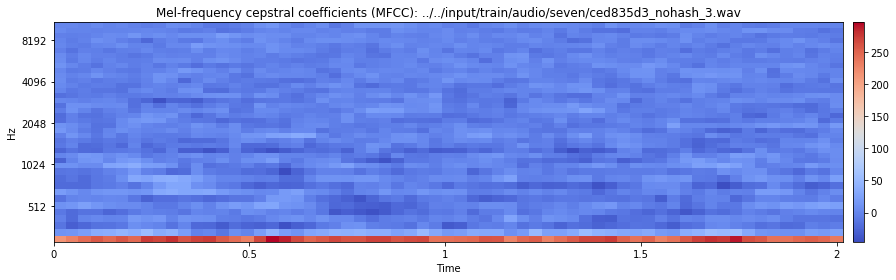

# "seven" [amplitude from -150 to 115, range = 265]

Unintelligible, noise.


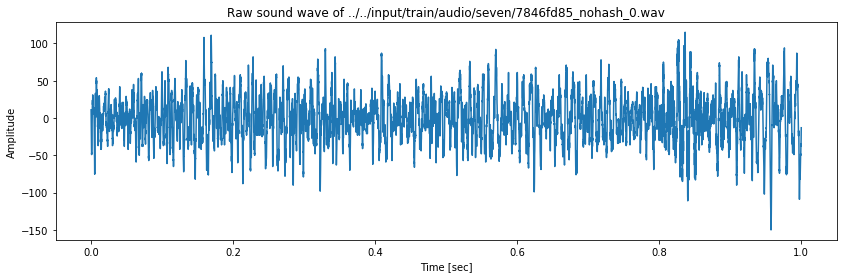

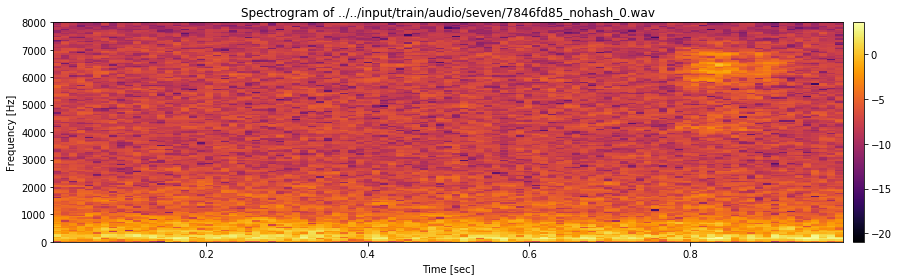

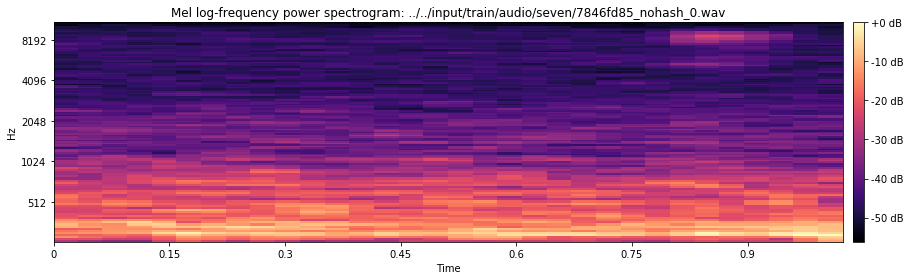

(40, 63)


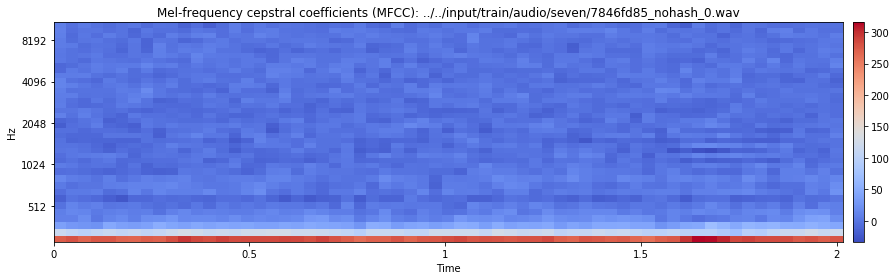

# "seven" [amplitude from -298 to 293, range = 591]

clicks with noise.


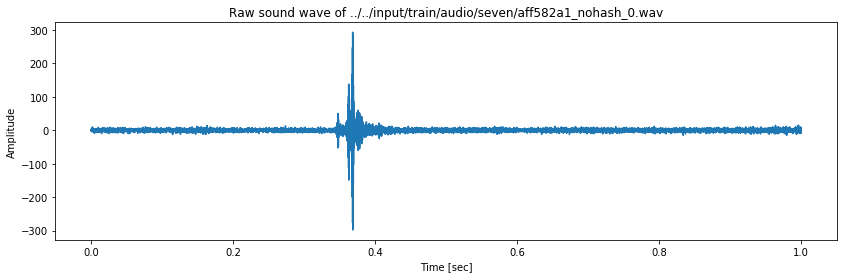

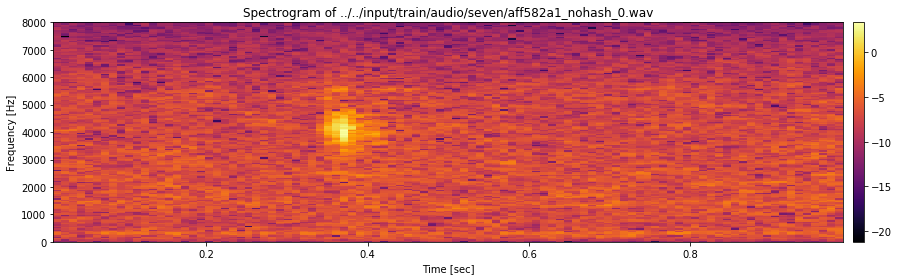

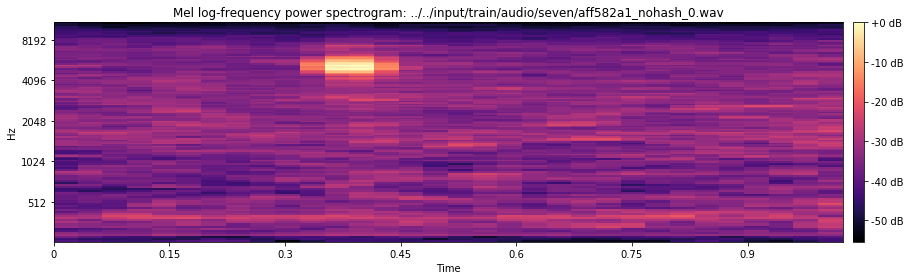

(40, 63)


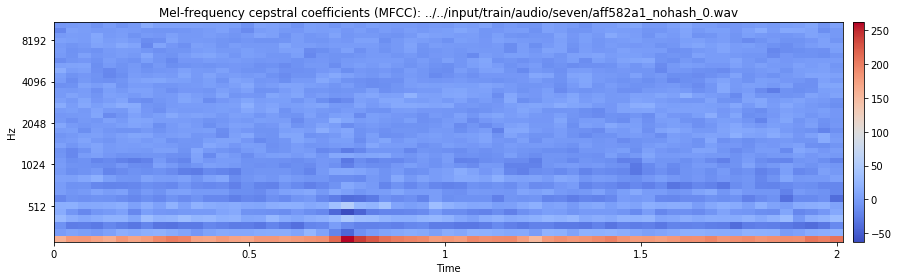

# "seven" [amplitude from -408 to 641, range = 1049]

"seven"


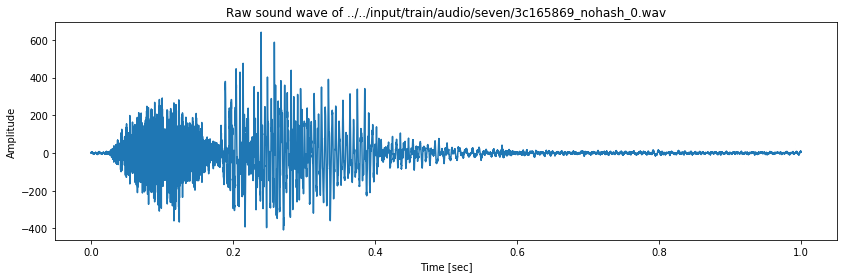

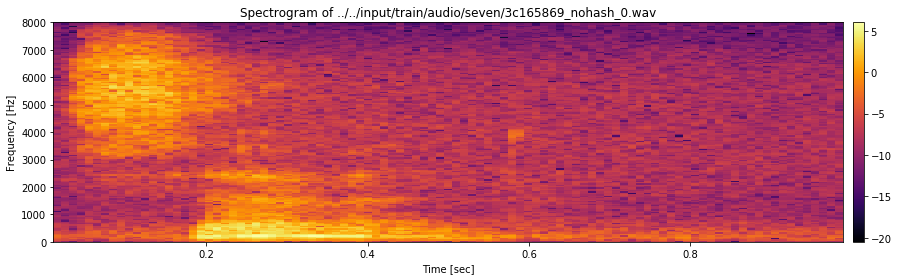

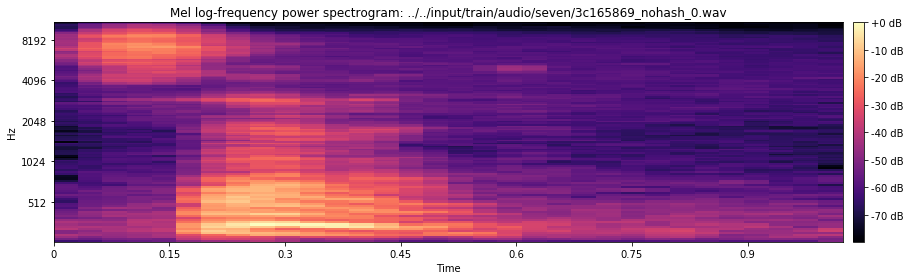

(40, 63)


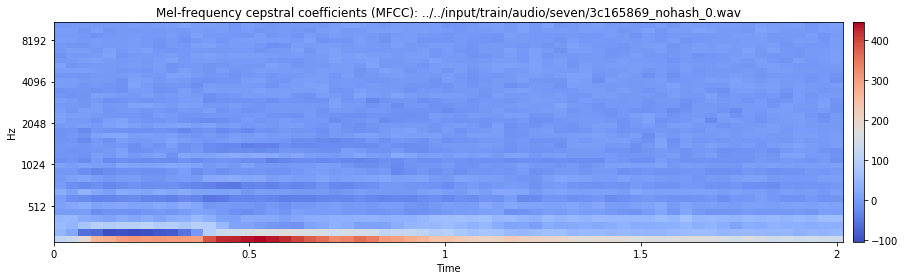

# "seven" [amplitude from -1284 to 800, range = 2084]

"seven"


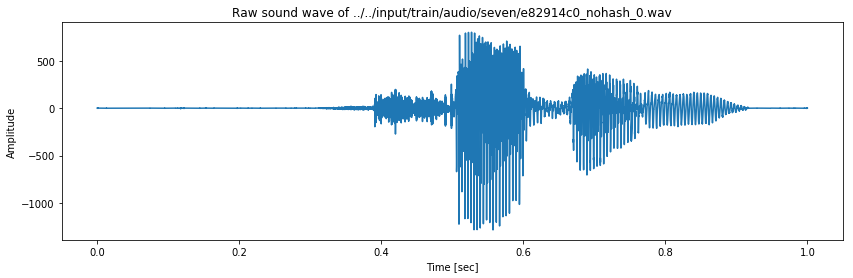

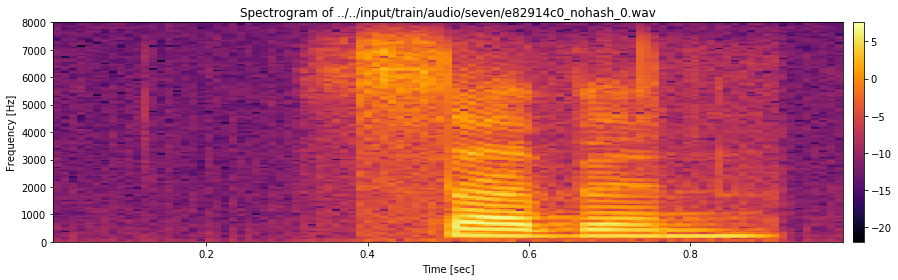

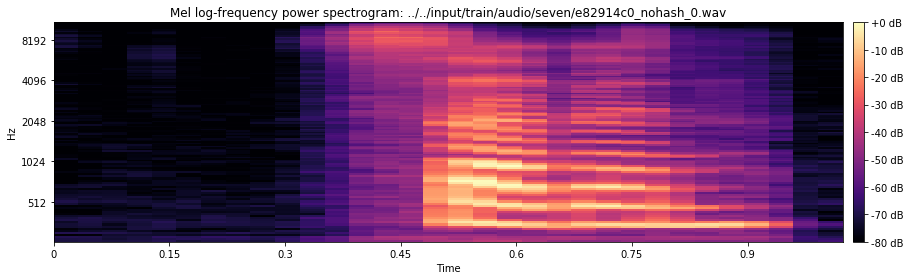

(40, 63)


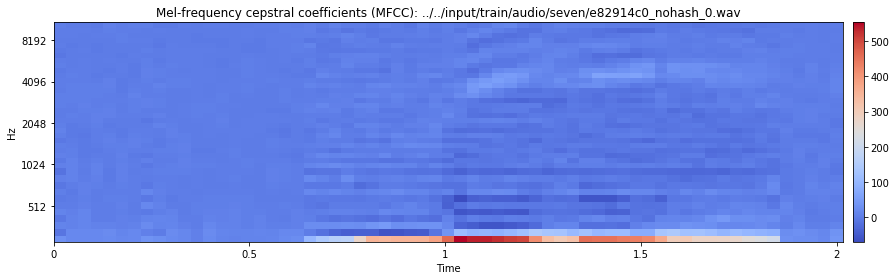

# "seven" [amplitude from -1767 to 2347, range = 4114]

"seven"


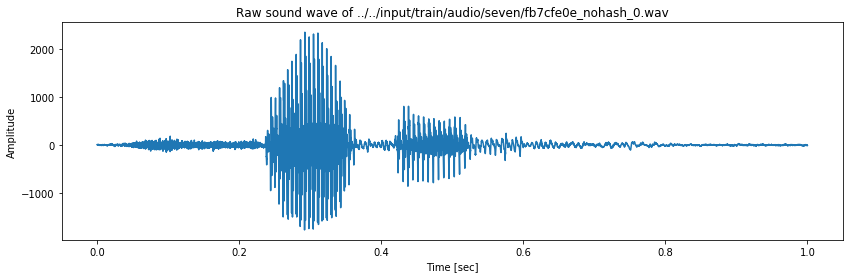

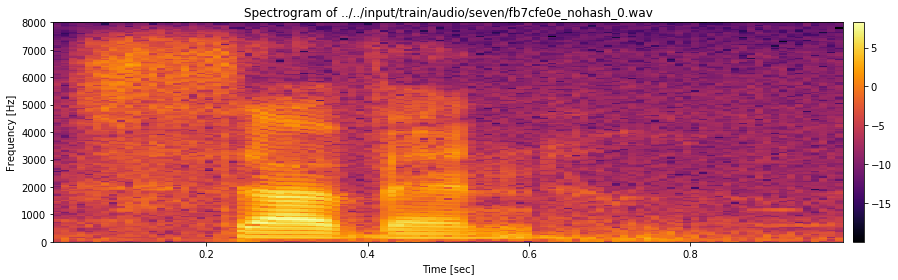

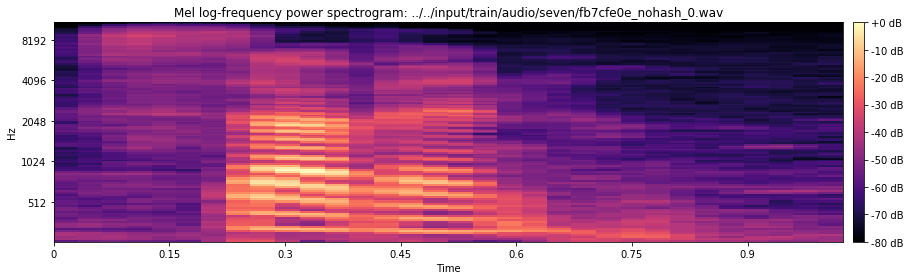

(40, 63)


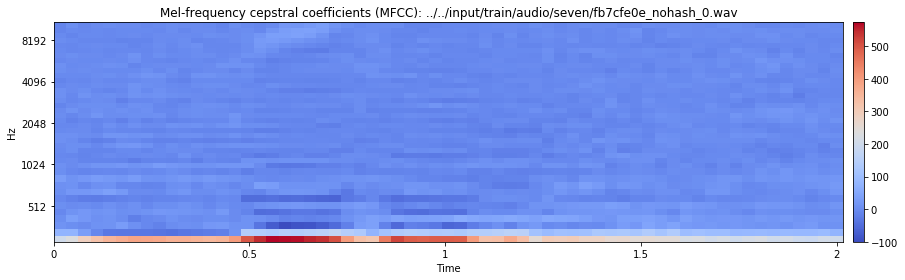

# "seven" [amplitude from -4190 to 4003, range = 8193]

Muffled "seven"


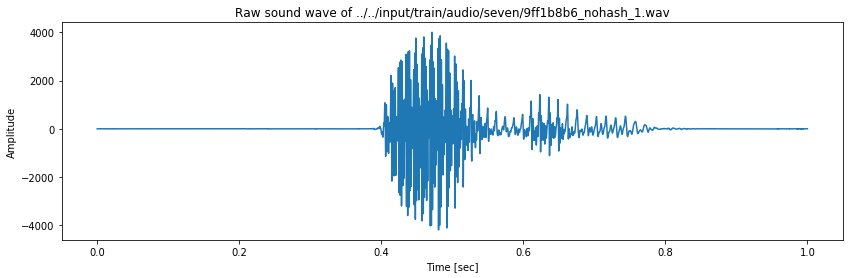

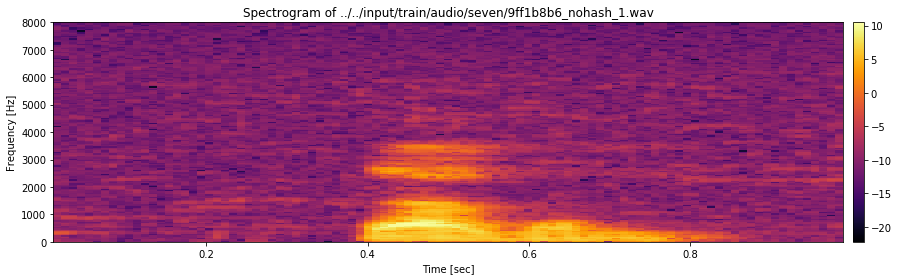

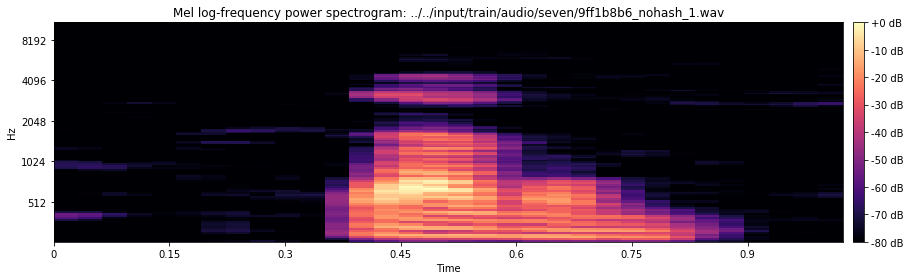

(40, 63)


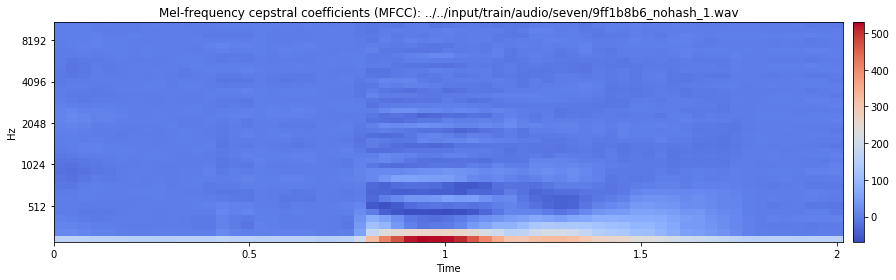

# "seven" [amplitude from -7579 to 8861, range = 16440]

"seven"


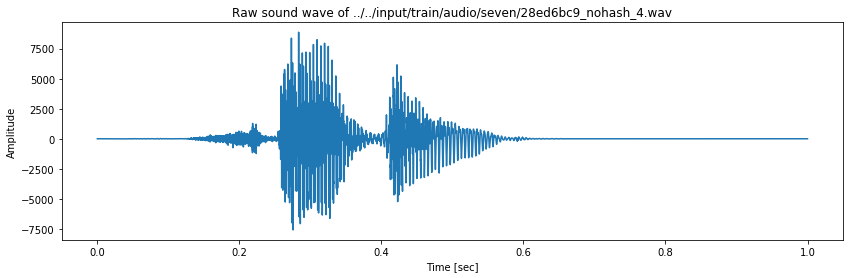

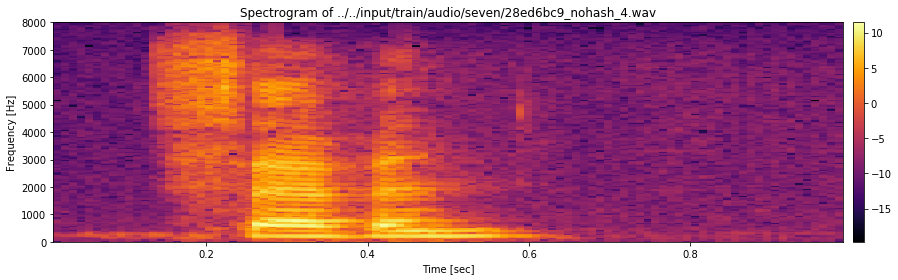

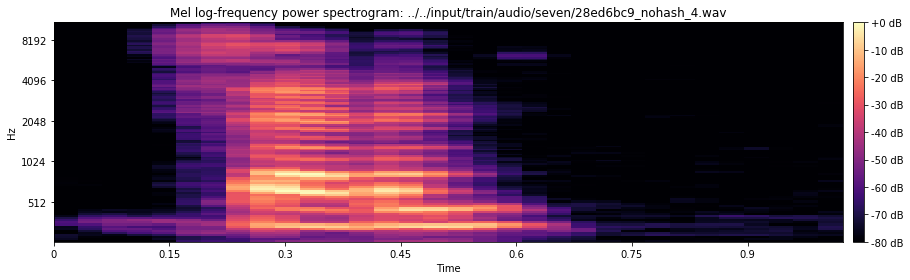

(40, 63)


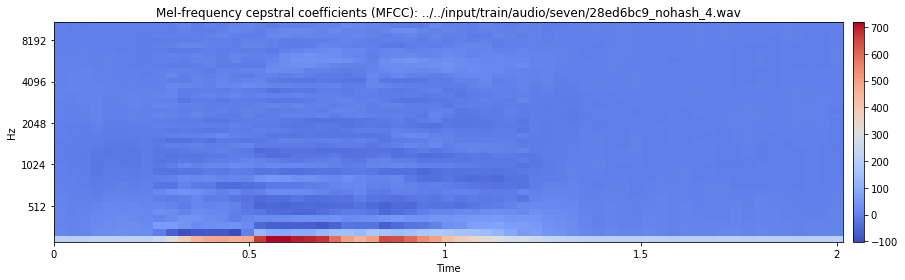

# "seven" [amplitude from -19862 to 12938, range = 32800]

noisy "seven"


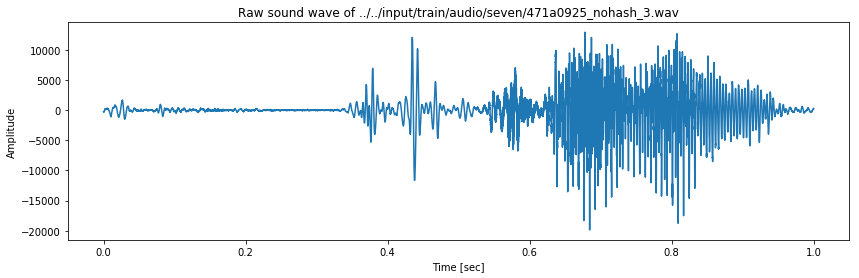

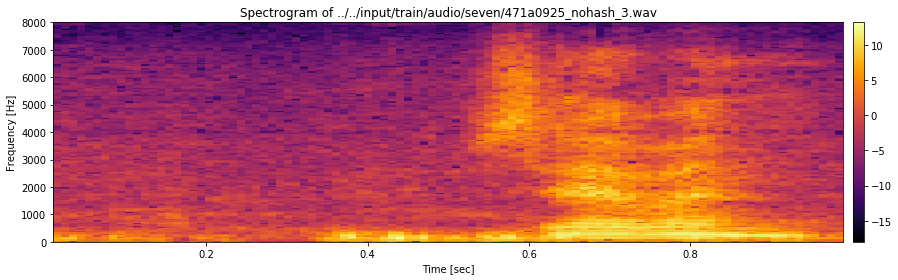

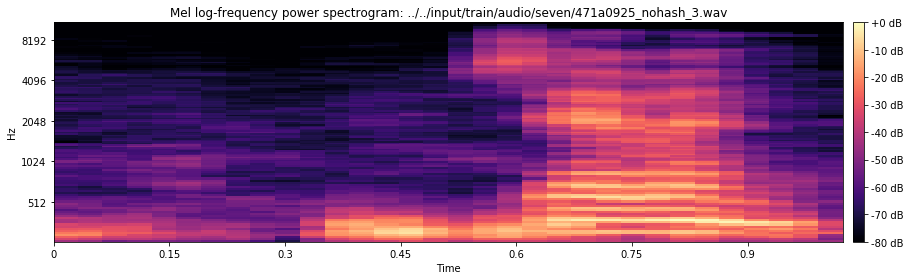

(40, 63)


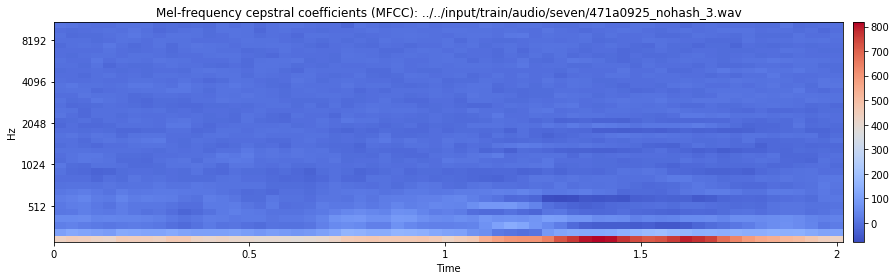

# "seven" [amplitude from -32768 to 32767, range = 65535]

LOUD "seven"


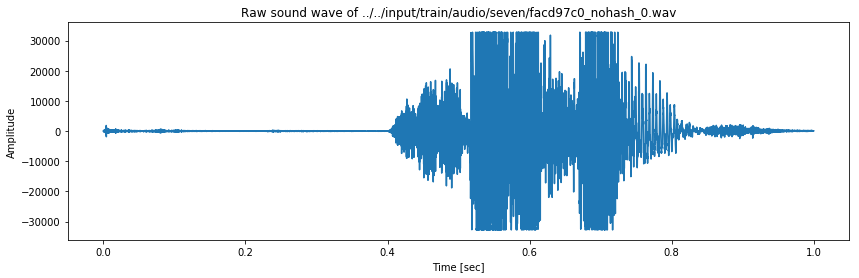

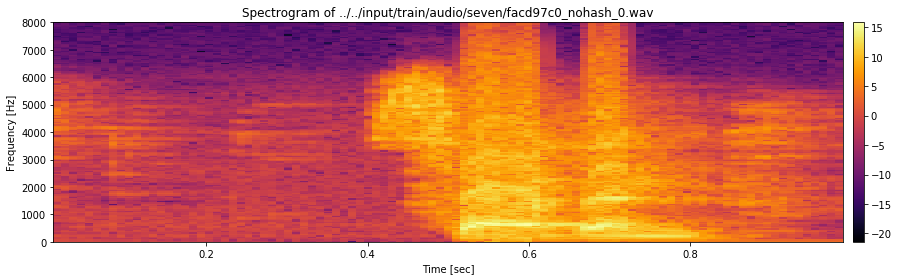

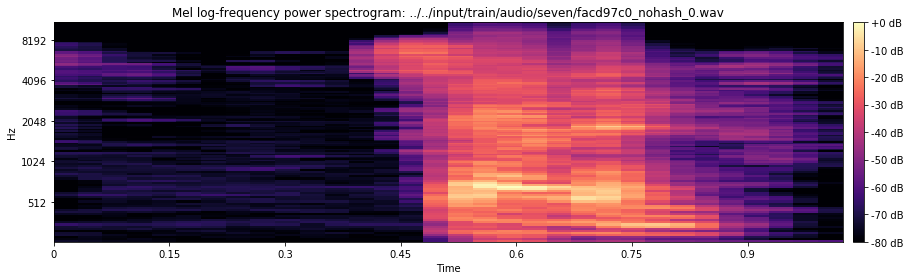

(40, 63)


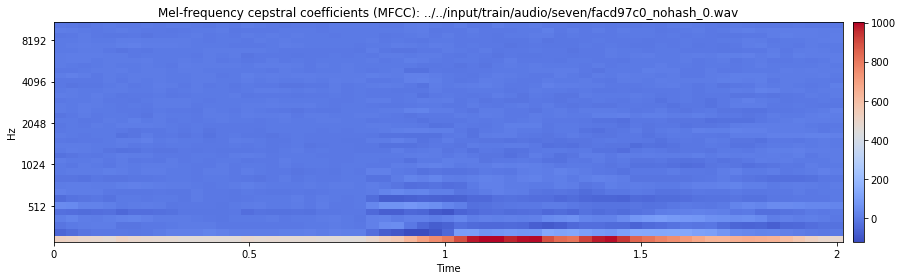

In [15]:
for i in range(wavedf.shape[0]):
    
    filenameShort = wavedf.loc[i, 'filename']
    word, wavename = filenameShort.split("/")
    
    filename = trainAudioPath + filenameShort
    
    sampleRate, samples = wavfile.read(filename)  
    caption = '"' + word  + \
    '" [amplitude from ' + str(min(samples)) +  ' to ' + str(max(samples)) + \
    ', range = ' + str(int(max(samples)) - int(min(samples))) + ']'
    
    printMarkdown("# " + caption)
    print(wavedf.loc[i, 'comments'])
    
    ipd.display( ipd.Audio(filename) )
    sampleRate, samples, logSpectrogram, logMelSpectrogram, mfcc = showWavefile(filename)

## "Flipped" Experiment


### Original

In [16]:
i = 10
#i = 6

filenameShort = wavedf.loc[i, 'filename']
word, wavename = filenameShort.split("/")
    
filename = trainAudioPath + filenameShort
sampleRate, samples = wavfile.read(filename)  

caption = '"' + word  + \
    '" [amplitude from ' + str(min(samples)) +  ' to ' + str(max(samples)) + \
    ', range = ' + str(int(max(samples)) - int(min(samples))) + ']'
    
printMarkdown("# " + caption)
print(wavedf.loc[i, 'comments'])
    
ipd.display( ipd.Audio(filename) )

# "seven" [amplitude from -19862 to 12938, range = 32800]

noisy "seven"


### Flipped

In [17]:
flipped = -samples
FLIPPED_FILENAME = 'flipped.wav'
wavfile.write(FLIPPED_FILENAME, sampleRate, flipped.astype(np.int16))
ipd.display( ipd.Audio(FLIPPED_FILENAME) )

Note change in scale for Delta

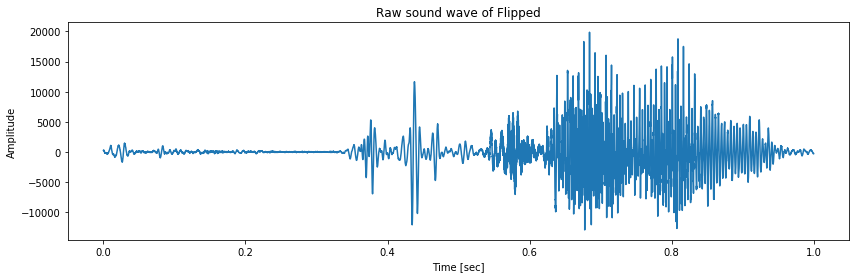

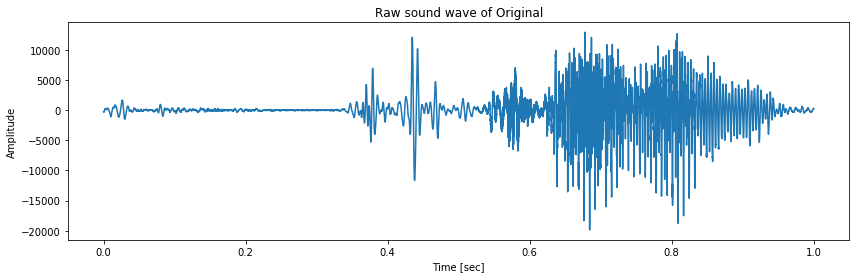

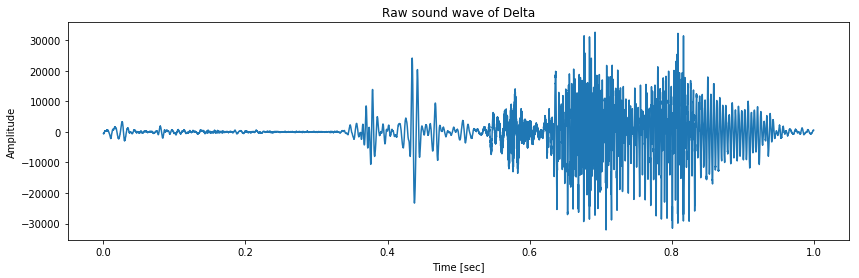

In [18]:
plotRawWave('Flipped', sampleRate, flipped, figWidth=14, figHeight=4)
plotRawWave('Original', sampleRate, samples, figWidth=14, figHeight=4)
plotRawWave('Delta',    sampleRate, samples - flipped, figWidth=14, figHeight=4)